# 03. 探索的データ分析（EDA Overview）

---

## 📌 TL;DR（このNotebookでやること）

このNotebookは **「モデリング前の地ならし」** として、離職率（全体・新卒・既卒）の分布と地域差を可視化し、主要特徴量との関係を俯瞰します。  
目的は **“当てにいく” ことではなく、次（04_modeling）の仮説と候補特徴量を絞ること** です。

---

## 🔎 Notebook Purpose（役割）

- 目的変数（離職率3種）の分布・外れ値・地域差の“形”を把握する  
- 主要特徴量との関係（相関）を広くスクリーニングし、深掘り候補を抽出する  
- 以降の `04_modeling.ipynb` に渡す **仮説・候補特徴量・注意点（リーク/多重共線性/欠損）** を整理する

---

## 📥 Input（前提）

- 統合マスターデータ（都道府県 × 公的統計）
  - `data/processed/nurse_data_clean.csv`
  - ※ 生成元：`01_create_master_dataset.ipynb`
- データ定義・クリーニング方針：`02_data_validation.ipynb`（または `01_data_validation.ipynb`）を参照

---

## 📤 Output（このNotebookの成果物）

- 離職率（全体・新卒・既卒）の **分布図 / 箱ひげ図**  
- 主要特徴量との **相関俯瞰**（相関ランキング含む）  
- `04_modeling.ipynb` に渡す：
  - 深掘り候補特徴量（Top-N）
  - 想定される仮説（例：都市コスト／定住性／労働負荷／市場構造）
  - 注意点（欠損・外れ値・解釈の落とし穴）

---

## 🧭 Analytical Design（分析の流れ）

1. **目的変数の健全性チェック**：基本統計 → 分布確認  
2. **地域差の把握**：分布の歪み／外れ値／レンジ感を把握  
3. **スクリーニング**：主要特徴量との相関を広く当てる（探索）  
4. **候補抽出**：相関ランキングで深掘り対象を確定  
5. **次工程への引き継ぎ**：仮説と候補特徴量を `04_modeling` へ

---

## 📝 Notes（読み方）

- ここでの相関は **因果の証明ではなく、仮説生成のための“手がかり”**  
- サンプルは 47 都道府県の集計なので、相関の強弱は **解釈よりも一貫性（再現性）** を優先して扱う


In [1]:
# ---------------------------------------------------------
# 1. 分析の準備（ライブラリとデータの読み込み）
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# 日本語表示（Mac環境向け）
import japanize_matplotlib

# 見た目の統一（ここで1回だけ）
sns.set_theme(style="whitegrid", font="Hiragino Sans")
plt.rcParams["figure.figsize"] = (10, 6)

DATA_PATH = Path("../data/processed/nurse_data_clean.csv")
df = pd.read_csv(DATA_PATH)

print("データの読み込み完了！データのサイズ:", df.shape)
display(df.head())


データの読み込み完了！データのサイズ: (47, 23)


,prefecture,turnover_total,nurse_per_100k,annual_income,night_shift_72h_plus,metro_a,metro_b,job_openings_ratio,turnover_new_grad,turnover_experienced,...,hospital_count,large_hospital_count,large_hospital_ratio,hospital_per_100k,population,overtime_hours,night_shift_3_avg,night_shift_2_avg,average_age,population_density
0,北海道,11.5,1306.9,478.90,36.7,0,0,1.12,5.9,16.6,...,534,17,3.18,10.5,5092,5,7.8,4.6,42.0,64.9
1,青森県,8.6,1118.2,435.22,36.5,0,0,1.30,10.7,16.7,...,89,3,3.37,7.5,1184,5,7.7,4.8,42.0,122.8
2,岩手県,6.8,1217.9,458.97,11.8,0,0,1.32,7.8,19.1,...,91,2,2.20,7.8,1163,3,7.5,4.1,46.0,76.1
3,宮城県,9.1,934.4,535.80,30.2,0,0,1.34,7.1,12.4,...,135,7,5.19,6.0,2264,6,8.0,4.7,40.0,310.9
4,秋田県,7.4,1265.3,524.81,25.1,0,0,1.47,5.0,7.3,...,64,3,4.69,7.0,914,4,7.7,4.3,44.9,78.5


In [2]:
# ---------------------------------------------------------
# 2. 離職率3種（目的変数）の基本統計
# ---------------------------------------------------------

turnover_cols = ["turnover_total", "turnover_new_grad", "turnover_experienced"]

display(df[turnover_cols].describe().T)
print("missing rows (any turnover):", df[turnover_cols].isna().any(axis=1).sum())


,count,mean,std,min,25%,50%,75%,max
turnover_total,47.0,10.142553,1.887573,6.8,8.70,10.0,11.6,14.2
turnover_new_grad,47.0,7.889362,2.273021,2.8,6.30,7.9,9.4,15.2
turnover_experienced,47.0,15.119149,3.145434,7.3,13.85,14.7,16.8,22.4


missing rows (any turnover): 0


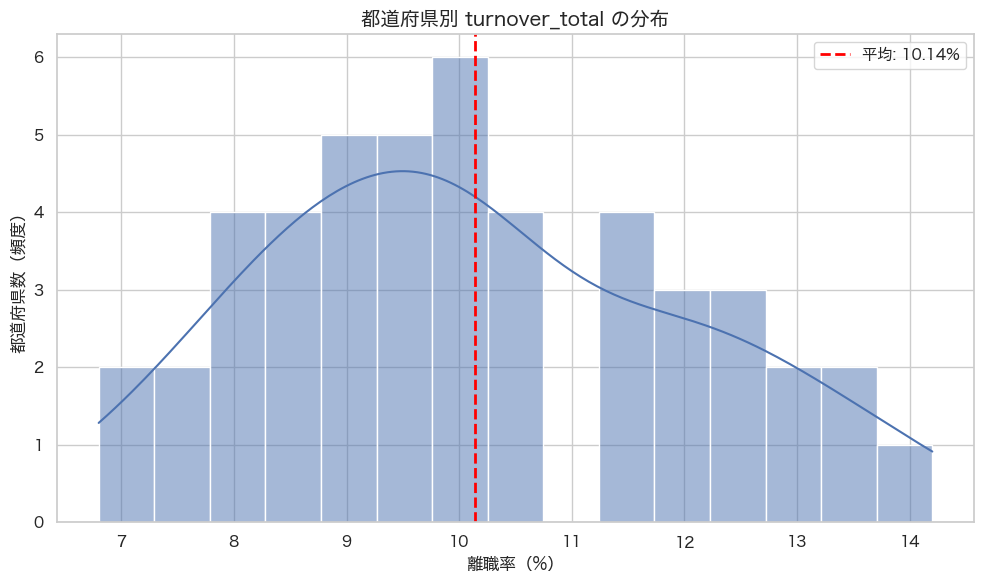

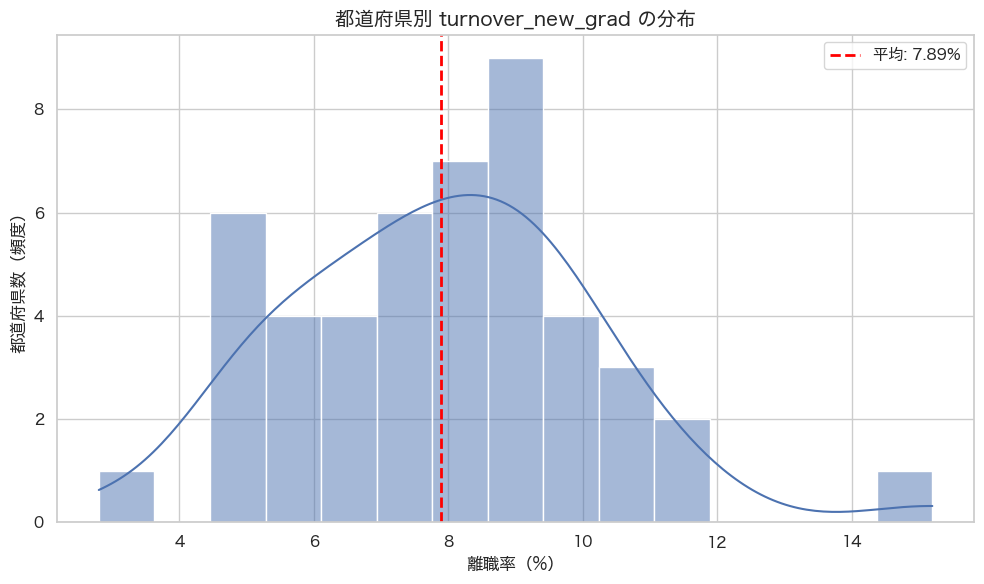

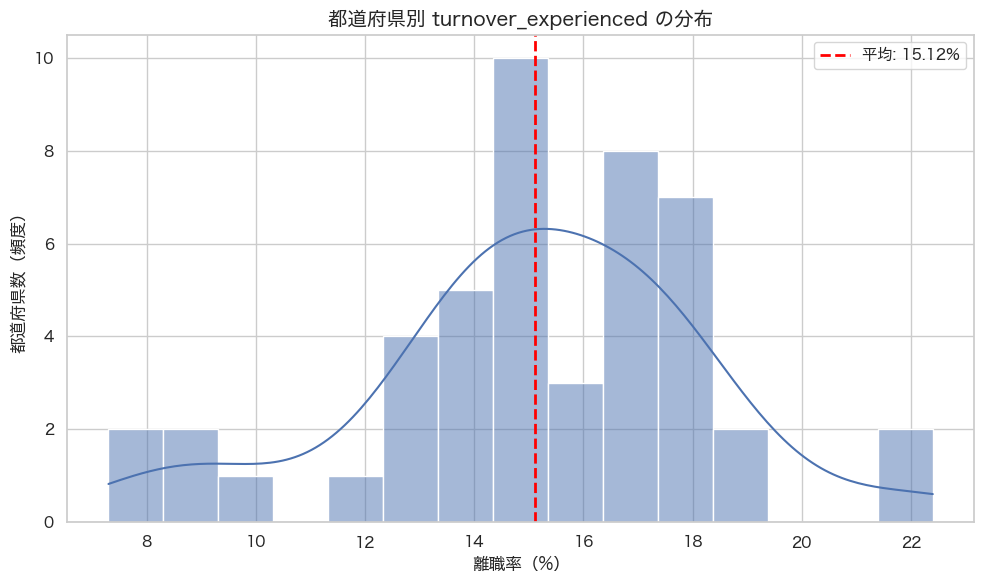

In [3]:
# ---------------------------------------------------------
# 3. 離職率3種の分布（ヒストグラム + KDE）
# ---------------------------------------------------------

for c in turnover_cols:
    plt.figure(figsize=(10, 6))

    # ヒストグラム + KDE
    sns.histplot(df[c], kde=True, bins=15, edgecolor="white")

    # 平均線
    mean_val = df[c].mean()
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"平均: {mean_val:.2f}%")

    plt.title(f"都道府県別 {c} の分布", fontsize=14)
    plt.xlabel("離職率（%）", fontsize=12)
    plt.ylabel("都道府県数（頻度）", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()


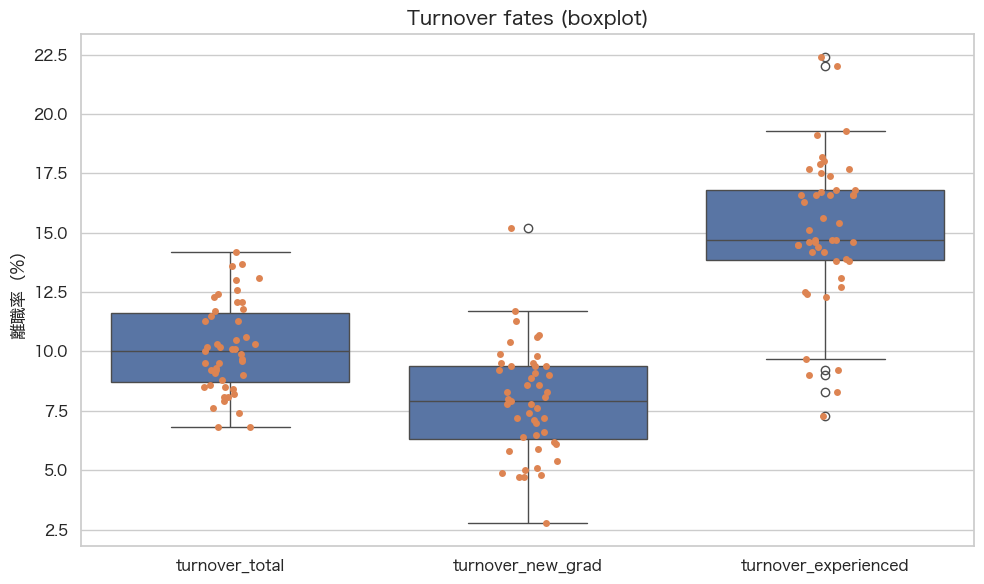

In [4]:
# ---------------------------------------------------------
# 4. 離職率3種の比較（箱ひげ図 + 点）
# ---------------------------------------------------------

# 統計解析や可視化ライブラリの仕様に合わせ、Wide形式のデータをLong形式へ「Unpivot（列の持ち替え）」してTidy Dataを構築
plot_df = df[turnover_cols].melt(var_name="turnover_type",value_name="turnover_rate")

# 描画キャンバスの初期化を行い、複数変数を比較するための適切なアスペクト比を設定
plt.figure(figsize=(10,6))

# 四分位範囲（IQR）に基づき、データのばらつき、中央線、外れ値の発生状況を「集計可視化」
sns.boxplot(data=plot_df,x="turnover_type",y="turnover_rate")

# 箱ひげ図上に全サンプル（Raw Data）を「オーバーレイ」し、実際のデータの密度と偏りを可視化
sns.stripplot(data=plot_df,x="turnover_type",y="turnover_rate")

# レポートとして視認性を確保するため、メタデータの定義を実行
plt.title("Turnover fates (boxplot)",fontsize=14)
plt.xlabel("") # カテゴリ名がX軸に並ぶため、冗長なラベルを抑制
plt.ylabel("離職率（%）") # データスケール（単位）を明示

# グラフ要素の配置を最適化し、ラベルの重なりを防ぐ「Layout Optimization」を適用
plt.tight_layout()

# 生成した可視化オブジェクトをレンダリングし、最終的な出力結果を確定
plt.show()

,turnover_total,turnover_new_grad,turnover_experienced
turnover_total,1.000000,0.279137,0.407347
population,0.723561,0.352676,0.235203
hospital_count,0.709456,0.359166,0.345331
metro_b,0.707043,0.300480,0.250710
metro_a,0.693038,0.276563,0.211894
rent_private,0.683978,0.248249,0.086828
large_hospital_count,0.676880,0.330123,0.174883
population_density,0.628543,0.393475,0.185158
commute_time,0.538162,0.140154,0.179047
turnover_experienced,0.407347,0.252459,1.000000


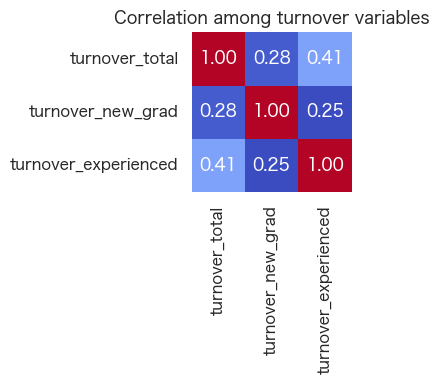

In [5]:
# ---------------------------------------------------------
# 5. 相関（離職率 × 主要変数の俯瞰）
# ---------------------------------------------------------

#　相関演算におけるエラーを防ぐため、数値型（Quantitative）のカラムのみをプロファイリング対象として抽出
num_df = df.select_dtypes(include=[np.number])

# 全変数間の線形関係を数値化する「相関行列（Correlation Matrix）」を計算（デフォルトはピアソン相関）
corr = num_df.corr()

# 1.特定の目的変数（離職率）に対して影響度の強い因子を特定する「ターゲット相関分析」を実行
# 転置（.T）して降順ソートすることで、正の影響が強い「要主要（Predictors）」をランキング形式で抽出
display(corr.loc[turnover_cols].T.sort_values(by="turnover_total",ascending=False).head(20))

# 2.目的変数間の「多重共線性（Multicollinearity）」や冗長性を確認するための視覚的診断
plt.figure(figsize=(6,4))
sns.heatmap(
    corr.loc[turnover_cols,turnover_cols], # 離職率３種のみにスコープを絞った部分行列を抽出
    cmap="coolwarm", # マイナスは青色、プラスは赤色に設定
    annot=True,      # 各セルに相関係数を直接表示し、読み取りミスを防止
    fmt=".2f",       # 浮動小数点数２桁に丸め、視認性を最適化
    square=True,     # 各セルを正方形に固定し、ヒートマップの歪みを抑制
    cbar=False       # 項目が少ないため、冗長なカラーバーを排除
)
plt.title("Correlation among turnover variables",fontsize=12)
plt.tight_layout() # グラフのラベル被りを防ぐレイアウト最適化
plt.show()

In [6]:
# ---------------------------------------------------------
# 6. 相関ランキング（深掘り候補の抽出）
# ---------------------------------------------------------

# 分析の焦点となる「目的変数（ラベル）」を指定し、相関分析の基準軸を固定
target = "turnover_total"

# 自己相関（１.0）を除外した「ターゲット相関ベクトル」を生成し、欠損地によるノイズを排除
series = corr[target].drop(index=target).dropna()

# 正の相関が強い「促進要因（Positive Predictors）」の上位１０件を抽出
top_pos = series.sort_values(ascending=False).head(10)

# 負の相関が強い「抑制要因（Nagative Predictors）」の上位10件を抽出
top_neg = series.sort_values(ascending=True).head(10)

# 相関の方向を問わず、影響度（絶対値）が最大となる「最重要特徴量(High-Impact Features)」を特定
top_abs = series.abs().sort_values(ascending=False).head(10)

# 各分析視点（正・負・絶対値）ごとのランキングを、意思決定者への報告用データフレームとして整形出力
display(pd.DataFrame({"top_positive_corr":top_pos}))
display(pd.DataFrame({"top_negative_corr":top_neg}))
display(pd.DataFrame({"top_absolute_xorr":top_abs}))

,top_positive_corr
population,0.723561
hospital_count,0.709456
metro_b,0.707043
metro_a,0.693038
rent_private,0.683978
large_hospital_count,0.676880
population_density,0.628543
commute_time,0.538162
turnover_experienced,0.407347
night_shift_2_avg,0.316390


,top_negative_corr
home_ownership_rate,-0.667490
job_openings_ratio,-0.636729
nurse_per_100k,-0.424046
night_shift_3_avg,-0.312734
hospital_per_100k,-0.279739
average_age,-0.144644
overtime_hours,0.089483
night_shift_72h_plus,0.232680
annual_income,0.233875
large_hospital_ratio,0.255287


,top_absolute_xorr
population,0.723561
hospital_count,0.709456
metro_b,0.707043
metro_a,0.693038
rent_private,0.683978
large_hospital_count,0.676880
home_ownership_rate,0.667490
job_openings_ratio,0.636729
population_density,0.628543
commute_time,0.538162


## ⚠ Limitations（制約）

- 集計データ（都道府県単位）であり、個人レベルの因果は示せない  
- 相関は交絡の影響を受けるため、解釈は `04_modeling` の多変量検証に委ねる  

---

## 🚀 Next（次にやること）

- `04_modeling.ipynb` で、EDAで抽出した候補特徴量を用いて回帰モデルを構築  
- 多重共線性（VIF）や残差診断、モデルの安定性を確認し、最終モデルを選定する  

---

## 🎯 Project Status（現時点の到達点）

このNotebookで **「深掘りすべき候補特徴量」と「検証すべき仮説」** を確定し、  
次工程（モデリング）で再現性のある検証に移行できる状態にした。
